# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Project Motive

By above information:
   * What are the main factors that defines the usage of offers by customers (Feature importance)
   * Probablity that the user will open and use the offer (Effectiveness of an offer)
   * Is there anything common between customers that we can deduce using demographics who take up an offer?
   * Finally predicting given an effective offer, how much will the customers spend based on demographics?
    

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,mean_squared_error,classification_report
from time import time
from sklearn.model_selection import GridSearchCV

# EDA process

Let's make an over view of each dataset, so we can more insights like percentage of missing values and distibution of data.

### 1.Portfolio

In [2]:
print(portfolio.shape)
portfolio

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


    1. Scale of features are distinct each other, they should be conisder for feature scaling.
    2. No missing id, all have unique id's.
    3. If we observe we have 3 different offer_type's BOGO, Discount, Informational.
    4. Finally Channel I think it would be enrich information through-out solving the case, we will encode it.

### 2.Profile

In [3]:
print('Profile Dataset information \n')
profile.info()

Profile Dataset information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.head(8)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [10]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
profile[profile['age']==118][['age','gender','income']].head(10)

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
9,118,None,NaN
10,118,None,NaN
11,118,None,NaN
17,118,None,NaN
23,118,None,NaN


* Intersting when there is an None in gender and Nan in income column.
* Both have same 2175 missing values.
* Last, age with 118 confirm's that we can drop these 2175 rows information. Since it carrying all None information.

In [3]:
# removing Missing Values
value_counts = profile['age'].value_counts()
to_remove = value_counts[value_counts == 2175].index
profile = profile[~profile.age.isin(to_remove)]
profile.shape

(14825, 5)

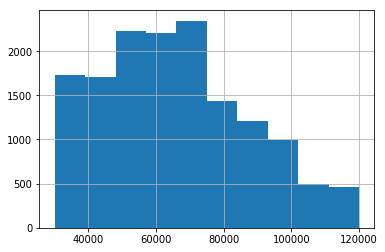

In [17]:
profile['income'].hist()

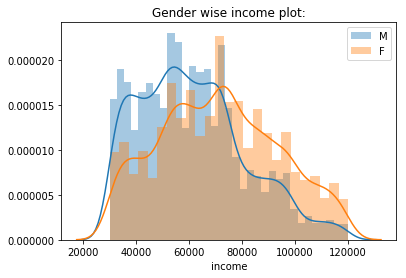

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(profile[profile.gender == 'M'].income,label='M')
sns.distplot(profile[profile.gender == 'F'].income,label='F')
plt.title('Gender wise income plot:')
plt.legend()
plt.show()

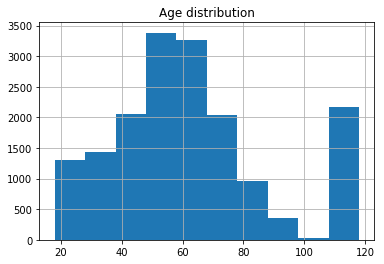

In [27]:
profile['age'].hist()
plt.title('Age distribution')
plt.show()

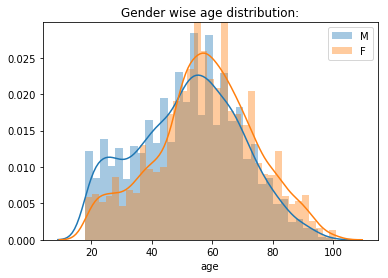

In [28]:
sns.distplot(profile[profile.gender == 'M'].age,label='M')
sns.distplot(profile[profile.gender == 'F'].age,label='F')
plt.title('Gender wise age distribution:')
plt.legend()
plt.show()

    * It seems 118 is completely out of control like outlier

### 3.Transcript Dataset

In [2]:
print('Transcript information : \n')
transcript.info()

Transcript information : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [30]:
transcript.head(7)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


    Value column carrying unique offer id and which is same 'id' column name in portfolio dataset, will rename 'id' column in portfolio to 'offer id' would be ease to map after data manipulation of 'value' column

In [35]:
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [3]:
portfolio = portfolio.rename(columns = {'id':'offer_id'})
portfolio.head(3)

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


In [4]:
# Value column should needs to be preprocess
transcript = pd.concat([transcript,transcript['value'].apply(pd.Series)],axis = 1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [8]:
print('offer_id column')
print(transcript.offer_id.unique(),'\n')
print('[offer id] column')
print(transcript['offer id'].unique())

offer_id column
[nan '2906b810c7d4411798c6938adc9daaa5' 'fafdcd668e3743c1bb461111dcafc2a4'
 '9b98b8c7a33c4b65b9aebfe6a799e6d9' 'ae264e3637204a6fb9bb56bc8210ddfd'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' '2298d6c36e964ae4a3e7e9706d1fb8c2'
 'f19421c1d4aa40978ebb69ca19b0e20d' '0b1e1539f2cc45b7b9fa7c272da2e1d7'] 

[offer id] column
['9b98b8c7a33c4b65b9aebfe6a799e6d9' '0b1e1539f2cc45b7b9fa7c272da2e1d7'
 '2906b810c7d4411798c6938adc9daaa5' 'fafdcd668e3743c1bb461111dcafc2a4'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' 'f19421c1d4aa40978ebb69ca19b0e20d'
 '2298d6c36e964ae4a3e7e9706d1fb8c2' '3f207df678b143eea3cee63160fa8bed'
 'ae264e3637204a6fb9bb56bc8210ddfd' '5a8bc65990b245e5a138643cd4eb9837' nan]


In [12]:
print(transcript['offer id'].isnull().sum())
print(transcript['offer_id'].isnull().sum())
print(transcript.shape)

172532
272955
(306534, 8)


We have 'offer id' and 'offer_id' columns carrying information, let just ensure and make it single id column.

In [5]:
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),
                                  transcript['offer_id'],transcript['offer id'])

# Drop the un neccessary columns 
transcript = transcript.drop(['offer id','offer_id'],axis = 1)
transcript.head(5)

,event,person,time,value,amount,reward,clean_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [6]:
# Let rename clean_id to offer_id, it would be ease to map with other datasets while merging
transcript.rename(columns = {'clean_id':'offer_id'}, inplace = True)
transcript.head(3)

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5


Let merge the transcipt and portfolio datasets. So we can retrive offer_type and event information in detail.

In [7]:
trans_port = pd.merge(transcript,portfolio,how = 'left',on = 'offer_id')

In [8]:
trans_port.head(5)

,event,person,time,value,amount,reward_x,offer_id,channels,difficulty,duration,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


In [11]:
trans_port.groupby(['offer_type','event']).person.count()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
Name: person, dtype: int64

We can observe that for informational there is no 'offer completed', it means 'transaction' should consider as informational offer completed.

In [12]:
trans_port.groupby(['event','offer_type']).person.count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: person, dtype: int64

We can see for informational offer_type, there is no association with 'offer completed' and thus transaction could be 'offer completed' event.

## Pre Processing

1. Assigning offer ids to transactions
    * we now have to assign offer_id to specific transactions as there is no offer id associated
    * We can classify our customers into below 4 case studies:
    
        i.People who are successfully completed - effective offers
            offer received -> offer viewed -> transaction -> offer completed (BOGO & Discount offer)
            offer received -> offer viewed -> transaction (informational - there might be limited offer period)
            
        ii.People received and viewed, but did not completed transaction - ineffective offers
            offer received -> offer viewed
        
        iii.People who purchase / complete offers regardless of awareness of any offers
            transaction
            offer received -> transaction -> offer completed -> offer viewed
            transaction -> offer recieved -> offer completed -> offer viewed
            offer received -> transaction -> offer viewed -> offer completed
            offer received -> transaction (Informational)
            offer received -> transaction -> offer viewed (Informational)
          
         iv. Offer received but no action
             offer received
             
## Defining the target variable effective offer:

* Group 1 Effective Offer :

    We know that group 1 customers will be our target variable "effective_offer" = 1.

###### ineffective offer list groups:

* Group 2 with in-effective offer:
    Group 2 where a user is aware of an offer, but the offer is ineffective as it does not convert the user into a customer.So group 2 can be defined as our target variable "effective_offer" = 0.

* Group 3 :
    Group 3 consists of users who may have received offers but would have purchased unknowingly. From the business point of view, we would not want to be sending them any offers.

* Group 4 :
    Group 4 users would be considered low priority customers, as they do not do any action, regardless of whether they receive offers or not.

So, we can give low importance to group 3 and group 4 from our model.

With above reference of checks, will assign the offer id that 'influences' a transaction by ensuring that the transaction occurs after an offer viewed event.

In [17]:
trans_port.columns

Index(['event', 'person', 'time', 'value', 'amount', 'reward_x', 'offer_id',
       'channels', 'difficulty', 'duration', 'offer_type', 'reward_y'],
      dtype='object')

In [8]:
# Will drop un-neccessary columns of left join reward columns from transcript_desc dataset
transcript_desc = pd.DataFrame(trans_port)

transcript_desc = transcript_desc.drop(columns = ['reward_x','reward_y'],axis = 1, inplace = False)
transcript_desc.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo


In [9]:
transcript_desc = transcript_desc.sort_values(['person','time'])
transcript_desc.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational


In [10]:
# filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_completed = transcript_desc[['time','offer_id','person','event']]\
[(transcript_desc['event'] == 'transaction')|(transcript_desc['event'] == 'offer viewed')]
offer_completed.head(10)

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,NaN,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,NaN,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed
228422,528,NaN,0009655768c64bdeb2e877511632db8f,transaction
233413,540,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,offer viewed
237784,552,NaN,0009655768c64bdeb2e877511632db8f,transaction
258883,576,NaN,0009655768c64bdeb2e877511632db8f,transaction
293497,660,NaN,0009655768c64bdeb2e877511632db8f,transaction


In [11]:
offer_completed.update(offer_completed.groupby(['person']).ffill())
offer_completed.head(5)

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed


In [12]:
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()
offer_completed.head(5)

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed


In [13]:
# Now we have ffill values for trandaction and offer viewed let apply complete subset to transacript_desc dataset
transcript_desc = transcript_desc.merge(offer_completed,how = 'left',on = ['person','time','event'])
transcript_desc.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


 We almost got updated all offer id's with keen let make them into single offer_id attribute

In [14]:
# Update offer_id details to transcript_Desc dataframe
transcript_desc['offer_id'] = np.where(transcript_desc['offer_id_x'].isnull(),transcript_desc['offer_id_y'],transcript_desc['offer_id_x'])

In [15]:
# Drop un neccessary columns of left join offer_id columns
transcript_desc.drop(columns = ['offer_id_x','offer_id_y'],axis = 1,inplace = True)
transcript_desc.head()

,event,person,time,value,amount,channels,difficulty,duration,offer_type,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [16]:
# we need to identify the data with particular offer_type, let just merge with portfolio to get those details into the dataset
transcript_desc = transcript_desc.merge(portfolio,how = 'left',on = 'offer_id')

transcript_desc['duration'] = np.where(transcript_desc['duration_x'].isnull(),\
                                       transcript_desc['duration_y'],transcript_desc['duration_x'])
# Removing all un neccessary columns from here
transcript_desc.drop(columns = ['duration_x',
                                'offer_type_x',
                                'difficulty_x',
                                'channels_x',
                                'duration_y'],axis = 1, inplace = True)

transcript_desc.rename(columns = {'channels_y':'channels',
                                  'reward_y':'reward',
                                  'difficulty_y':'difficulty',
                                  'offer_type_y':'offer_type'},inplace = True)

In [30]:
transcript_desc.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


### Flag out transactions and offers completed after offers viewed

The next important step for preparing our data for modeling and analysis is to identify a completed offer and transactions occurring after an offer is viewed.

Once we have assigned a transaction occurring after an offer is viewed, I can use that information to subset my data according to the groups defined above, and analyse within each group.

Since we've already filled all transaction's offer id, we can extract the transactions converted from offers by checking if the offer id before the transaction is the same as the transaction's offer id.

This means that as long as the events offer viewed,transaction, and offer completed occur in the same event space and are in the corrrect sequence of time, we can be assured that it is a transaction and/or completed offer occurring only after an offer is viewed.

To do this, I created a new column to flag the previous offer id using pandas' shift function.

In [17]:
# Consider offer viewed, transaction and offer completed events
transaction_after_view = transcript_desc[(transcript_desc['event'] == 'offer viewed')|
                                         (transcript_desc['event'] == 'transaction')|
                                        (transcript_desc['event'] == 'offer completed')].copy()

# Get previous previous offer_id's
transaction_after_view['pre_offer_id'] = transaction_after_view.groupby(['person','offer_id'])['offer_id'].shift()

# Let create completed_offer after viewing and completed offers
transaction_after_view['completed_offer'] = np.where(transaction_after_view
                                                     ['pre_offer_id'] == transaction_after_view['offer_id'],1,0)

transaction_after_view.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0


In [18]:
# Let go back to offer received which was not involved in the previous execution
offer_received = transcript_desc[transcript_desc['event'] == 'offer received']

offer_received['pre_offer_id'] = np.nan
offer_received['completed_offer'] = np.nan

transcript_desc = offer_received.append(transaction_after_view).sort_values(['person','time'])
transcript_desc.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


lets make 'offer type' wise differenciate the dataset. It would be ease to track all.

In [19]:
# Let us split our offer type category dataset's into respective identified dataset forms
bogo = transcript_desc[transcript_desc['offer_type']=='bogo'].copy()
informational = transcript_desc[transcript_desc['offer_type']=='informational'].copy()
discount = transcript_desc[transcript_desc['offer_type']=='discount'].copy()

In [20]:
bogo.head(2)

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,bogo,5.0,5.0,NaN,NaN
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,bogo,5.0,5.0,NaN,0.0


In [21]:
discount.head(2)

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,discount,2.0,10.0,NaN,NaN
11,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,discount,2.0,10.0,NaN,0.0


In [23]:
informational.head(2)

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,informational,0.0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,informational,0.0,3.0,NaN,0.0


Completed offer indicating that transactions and offers that it has completed successfully.
For BOGO and discount offers, we will only consider offer completed events as the conversion events, while we can consider transaction event as the conversion event for the informational offers.

In [20]:
## Let consider group1 people

bogo_completed = bogo[['person','offer_id']][(bogo['completed_offer']==1) & \
                                             (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_completed = discount[['person','offer_id']][(discount['completed_offer']==1) &\
                                                     (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

Now, we can look into separating group 2 and group 4 unique person-offer_ids for BOGO and discount offers. We can assume that every person who views an offer would have had an offer received event prior, so we can just take the whole group of people who received an offer and subset them into group 2 and 4 later.

for informational offers we will define group 1 later as there is an additional consideration we need to take into account for transactions - they need to occur within the validity period of an informational offer for us to consider them as effective offers

In [21]:
# will define a function to repeat it for BOGO and discount
def not_converted(df):
    '''
    inputs:
    df: original transcript dataframe of specific offer type 
    
    outputs:
    Returns dataframe containing unique person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events (transaction and offer_completed)
       
    '''
    # offer id's that have transactions by person and offer_id
    conversion_ids = df[['person','offer_id']][(df['event']=='transaction') | 
                                           (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
    
    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()
    
    # Will differenciate by merging conversion_id and offer_received table 
    check_merge = conversion_ids.merge(offers_received_only,how = 'right',on = ['person','offer_id'],indicator = True)
    
    return check_merge

#check how many are in either group
check_merge_bogo = not_converted(bogo)
print(check_merge_bogo.groupby(['_merge']).count(),'\n')

check_merge_discount = not_converted(discount)
print(check_merge_discount.groupby(['_merge']).count())

            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592 

            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


There are fair number of unique person-offer_id pairs that have offer received events, but no conversion events. These would be considered offers in group 2 and 4 within each offer type.

Then, based on merged dataset above, we can seperate out customers who only viewed the offer after they received the offer and customers who didn't even open the offer after they receive the offer.

In [22]:
grp_2_4_bogo = check_merge_bogo[check_merge_bogo['_merge'] == 'right_only']
grp_2_4_bogo = grp_2_4_bogo.merge(transcript_desc,how = 'left',on = ['person','offer_id'])

grp_2_bogo = grp_2_4_bogo[['person','offer_id']][grp_2_4_bogo
                                                 ['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_bogo.drop(['_merge'], axis=1, inplace=True)

grp_4_bogo=grp_2_4_bogo.merge(grp_2_bogo[['person','offer_id']],how='left',indicator=True)
grp_4_bogo=grp_4_bogo[grp_4_bogo['_merge']=='left_only'].copy()

In [23]:
# will apply same for discount offer as well

# Customers who received offer without finishing transaction
grp_2_4_discount = check_merge_discount[check_merge_discount['_merge']=='right_only']
grp_2_4_discount = grp_2_4_discount.merge(transcript_desc, how='left',on=['person','offer_id'])

# subset users who only viewed the offer and people who viewed the offer but didn't make transaction
grp_2_discount = grp_2_4_discount[['person','offer_id']][grp_2_4_discount
                                                         ['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_discount.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the discount offer 
grp_4_discount = grp_2_4_discount.merge(grp_2_discount[['person','offer_id']], how='left', indicator=True)
grp_4_discount = grp_4_discount[grp_4_discount['_merge']=='left_only'].copy()

Come to group 3 , these are the people who completed the offer and transaction. 

For BOGO and discount offers, they would be people with offer completed events that have completed_offer != 1.

In [24]:
grp3_bogo = bogo[['person','offer_id']][(bogo
                                         ['event'] == 'offer completed') & 
                                        bogo['completed_offer']!= 1].groupby(['person','offer_id']).count().reset_index()

grp3_discount = discount[['person','offer_id']][(discount['event'] == 'offer completed') 
                                               & discount['completed_offer'] != 1].groupby(['person','offer_id']).count().reset_index()

Lets consider effective and ineffective offers 

Group1: person_unique_id will be a effective and our target variable should be 1

Group2: person_unique_id, target variable will be 0

In [25]:
def effective_offer(df_grp1,df_grp2):
    '''
    input:
    Group1 & Group2 dataframe
    
    Output:
    Effective offer returns into target variable
    '''
    
    df_grp1['effective_offer'] = 1
    df_grp2['effective_offer'] = 0
    
    offer = df_grp1.append(df_grp2,sort = False)
    
    return offer

bogo_offer = effective_offer(bogo_completed,grp_2_bogo)
discount_offer = effective_offer(discount_completed,grp_2_discount)

Target varibales cleared for both BOGO and Discount

For informational we need to be careful about validaty of the offer.

### Informational dataset, set response variable

Informational:
* When we consider effective/converted transaction and offer for 'informational' type offers. The reason why informational offers get a different treatment is because the conversion event is not an offer completed event, but a transaction.

* An offer effective if it existed with in the duration

* As earlier we seen the dataset contains duration in terms of time of an event, we need to choose a days

First thing I should do here is to convert time data to days in informaitonal

In [42]:
informational.columns

Index(['event', 'person', 'time', 'value', 'amount', 'offer_id', 'channels',
       'difficulty', 'offer_type', 'reward', 'duration', 'pre_offer_id',
       'completed_offer'],
      dtype='object')

In [26]:
informational['offer_days'] = informational['time']/24

# Dropping unneccessary attributes from the list
informational.drop(['time','value','pre_offer_id'],axis = 1,inplace = True)

informational = informational.sort_values(['person','offer_days','event','offer_id'])
informational.head(4)

,event,person,amount,offer_id,channels,difficulty,offer_type,reward,duration,completed_offer,offer_days
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,7.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,0.0,8.0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,1.0,9.5
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,14.0


In [38]:
print(informational['event'].unique())
print(informational['offer_type'].unique())
print(informational['offer_type'].value_counts())

['offer received' 'offer viewed' 'transaction']
['informational']
informational    43501
Name: offer_type, dtype: int64


Will take a dfference between the transaction and offer received as the duration

In [27]:
informational['diff_duration'] = informational[(informational['event'] == 'transaction') |
              (informational['event'] == 'offer received')].groupby(['person','offer_id'])['offer_days'].diff()

Will make actual flag outs duration over to here, by comparing diff_duration and actual duration

In [28]:
# Let flag valid events
informational['Valid_offer'] = np.nan

# Let sure with in duration of time
informational.loc[informational['diff_duration']<= informational['duration'],'Valid_offer'] = 1

informational['Valid_offer'] = informational['Valid_offer'].fillna(value = 0)

In [39]:
informational.head(1)

,event,person,amount,offer_id,channels,difficulty,offer_type,reward,duration,completed_offer,offer_days,diff_duration,Valid_offer
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,7.0,NaN,0.0


We have two valid flags i.e. completed_offer and valid_offer

we have 2 * 2 = 4 poosible outcomes 

    case 1: completed_offer = 1 and valid_offer =0
        it means transction completed after offer viewed, but not with in duration. It means these are neither influcened by
        offer nor interset on it.
    case 2: completed_offer = 0 and valid_offer =1
        completed transaction with in duration, but no offer viewed. This is nothing but our group 3 people
    Case 3: completed_offer = 1 and valid_offer =1
           All did in right in time, we should say effective group of people ie.group1
    Case 4: completed_offer = 0 and valid_offer =0
            did not have any transction

In [29]:
# let put case3 as positive and remain as 0
informational['offer_responded'] = np.where((informational['completed_offer'] == 1) & (informational['Valid_offer'] ==1),1,0)

In [30]:
# Will consider group1 people
info_completed = informational[['person','offer_id']][informational
                                                      ['offer_responded'] == 1].groupby(['person','offer_id']).sum().reset_index()

For remaining people, we have separate out group 2 and 4. Since we don't have duration will use similar BOGO and discount steps.

In [31]:
check_merge_info = not_converted(informational)
print(check_merge_info.groupby(['_merge']).count())

            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [32]:
grp_2_4_info = check_merge_info[check_merge_info['_merge'] == 'right_only']
grp_2_4_info  = grp_2_4_info.merge(transcript_desc,how='left',on=['person','offer_id'])
grp_2_info = grp_2_4_info[['person','offer_id']][grp_2_4_info['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_info.drop(['_merge'], axis=1, inplace=True)
grp_4_info=grp_2_4_info.merge(grp_2_info[['person','offer_id']],how='left',indicator=True)
grp_4_info=grp_4_info[grp_4_info['_merge']=='left_only'].copy()

Group 3 we have to consider people with conversion events but no offer viewed event prior. For informational offers, these would be transactions in case 1 and 2.

In [45]:
informational['event'].unique()

array(['offer received', 'offer viewed', 'transaction'], dtype=object)

In [33]:
#let combine case1 and case 2 as group3
grp3_case1 = informational[['person','offer_id']][((informational
                                                    ['event'] == 'transaction') & 
                                                   (informational['completed_offer']!=1)) & 
                                                  (informational['Valid_offer'] ==1)].groupby(
    ['person','offer_id']).count().reset_index()

grp3_case2 = informational[['person','offer_id']][((informational
                                                    ['event'] == 'transaction') & 
                                                   (informational['completed_offer']==1)) & 
                                                  (informational['Valid_offer'] !=1)].groupby(
    ['person','offer_id']).count().reset_index()


grp3_info = grp3_case1.append(grp3_case2,sort = False)
del grp3_case1
del grp3_case2

Let append all datasets together make sure it is good to for modeling

In [34]:
info_offer = effective_offer(info_completed,grp_2_info)

In [54]:
print(info_offer['effective_offer'].unique())
info_offer.head(2)

[1 0]


,person,offer_id,effective_offer
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1


    Now we have target variable which is consisting of effective(1) and ineffective(0) offers depending on offer type.

# Feature Engineering

In [56]:
print(portfolio.columns)
print(profile.columns)

Index(['channels', 'difficulty', 'duration', 'offer_id', 'offer_type',
       'reward'],
      dtype='object')
Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')


### 1. became_member_on feature

In [35]:
# since bogo, discount, info are consistited of person varible as id, renaming id as person in profile dataset
profile.rename(columns = {'id':'person'},inplace = True)

In [190]:
print('lowest year',profile.sort_values(['became_member_on']).head(2))    #-->2013
print('\n')
print('highest year',profile.sort_values(['became_member_on']).tail(2))   #-->2018

lowest year       age  became_member_on gender                            person   income
8948   64          20130729      M  77388a70eaf14433b4efc5d01fa947bf  69000.0
7796   58          20130730      F  d25f38519a89455499c9e49e67ae1511  55000.0


highest year        age  became_member_on gender                            person   income
12902   85          20180726      M  f1f01be4e2344bf08b7f488c115ad374  45000.0
4357    76          20180726      M  6597e5ab63754726b83ba2032f008d26  92000.0


since became_member_on is date format let make it year, month, day to get when does he membered calculation.

In [36]:
def membership_since(df):
    '''
    input:
    dataframe with became_member_on
    output:
    since how many days he joins
    '''
    
    df = df.merge(profile,how = 'left',on = 'person')
    
    df['year'] = pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month'] = pd.Series([int(str(x)[-4:-2]) for x in df['became_member_on']])
    df['day'] = pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    
    df.loc[df['year'] == 2018,'since_he_membered'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018,'since_he_membered'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    
    df = df.drop(['year','month','day','became_member_on'], axis=1, inplace=False)
    
    return df

In [37]:
offers_bogo = membership_since(bogo_offer)

offers_discount = membership_since(discount_offer)

offers_info = membership_since(info_offer)

In [193]:
offers_bogo.head(4)

,person,offer_id,effective_offer,age,gender,income,since_he_membered
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,1071.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,1071.0


In [222]:
offers_discount.head(4)

,person,offer_id,effective_offer,age,gender,income,since_he_membered
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,O,57000.0,39.0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,O,57000.0,39.0
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,F,90000.0,824.0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,F,60000.0,1071.0


In [223]:
offers_info.head(2)

,person,offer_id,effective_offer,age,gender,income,since_he_membered
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,M,72000.0,506.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,M,72000.0,506.0


## 2. Count of offers received

As part of data insights, I have seen there could be multiple offers per person.The no of times each offers received by customer also can have effect on offers being effective or not.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
Name: event, dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


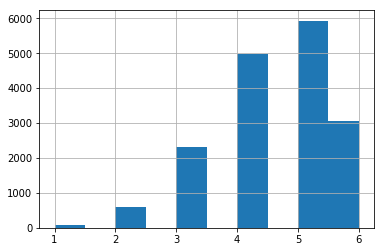

In [38]:
# A common point a person can receive a multiple offers lets check in our case.
print(transcript_desc[transcript_desc['event'] == 'offer received'].groupby('person')['event'].count().head(4))
print('\n')
print(transcript_desc[transcript_desc['event'] == 'offer received'].groupby('person')['event'].count().hist())

It states that a person max received 5-6 offers. 

In [39]:
df_offer_received_cnt = transcript_desc[transcript_desc['event']=='offer received'].groupby(
    ['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
df_offer_received_cnt.drop(['time'], axis=1, inplace=True)

#ensure only unique person-offer_id pairs
df_offer_received_cnt = df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

### 3. Get invalid transactions (which are not related to offers)
* The sum of transactions done by people not in group1, hence the people in group 1, a few users will have some predictive power onto the effectiveness of offers; since a loyal user might have a higher tendency of taking up an offer.

* In my datasets, I had already separated the transactions who are conversions versus transactions who are just the users' normal purchasing behaviour. This is through the completed_offer column, where I checked if a transaction had an offer viewed event prior.

* In the cases where offer_completed=1, I had already included them in my effective offers flag for BOGO and Discount offers. However, for those transctions where offer_completed=0, I have not considered them, and this could be a potential feature to include, as a proxy for the 'baseline' level of spending for a user.

* The logic is to wonder if there is some baseline level of spending for users who are highly influenced by certain offers (in group 1), and group 2, and if there is some predictive power in this baseline level of 'invalid transactions' that can predict the propensity of a user to take up an offer.

In [40]:
#filter dataset by invalid transactions
# subtract the transactions which's not related to the offer

transactions_not_related = transcript_desc[(transcript_desc['event']=='transaction') & 
                                           (transcript_desc['completed_offer']==0)].groupby(
    ['person','offer_id'])['amount'].sum().reset_index()


transactions_not_related.rename(columns={'amount':'amount_invalid'},inplace=True)

## Data Preperation steps for Modeling
a. Merge with temporary datasets created above to include engineered features

b. Drop missing values in gender,income and abnormal age value column for demographic data; convert gender into dummy variables

c. Separate the channel column into categorical variables

d. Treatment of duplicate records

In [41]:
offers_bogo = offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo = offers_bogo.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [42]:
# Missing value %
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid        96.323752
income                 7.057489
gender                 7.057489
offer_received_cnt     0.000000
since_he_membered      0.000000
dtype: float64

We can see that amount_invalid column has 97% missing data. Since it is so 'sparse' for BOGO offers, it might not have much information after all. We assess this feature again later during the model implementation phase. For now, we fill the missing amount_invalid column with 0.

In [43]:
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)
offers_bogo.dropna(inplace=True)

#### Separate the channel column into categorical variables

In [44]:
# will create a dummy function to map our dataset to manipulate towards encoding
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=df.drop(columns=col,axis=1,inplace=False)
    return df

In [45]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

#convert channels into categorical variables
for index, row in offers_bogo.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_bogo.loc[index, 'channels']:
            offers_bogo.loc[index, channel] = 1
        else:
            offers_bogo.loc[index, channel] = 0

In [46]:
offers_bogo.columns

Index(['person', 'offer_id', 'effective_offer', 'age', 'gender', 'income',
       'since_he_membered', 'offer_received_cnt', 'amount_invalid', 'channels',
       'difficulty', 'duration', 'offer_type', 'reward', 'web', 'email',
       'social', 'mobile'],
      dtype='object')

In [47]:
offers_bogo = offers_bogo.drop(['channels'], axis=1, inplace=False)

#convert gender into categorical variables
offers_bogo = dummy(offers_bogo,'gender')

In [95]:
offers_bogo.head()

,person,offer_id,effective_offer,age,income,since_he_membered,offer_received_cnt,amount_invalid,channels_x,difficulty_x,...,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39.0,1,0.0,"[web, email, mobile]",5,...,7,bogo,5,1.0,1.0,0.0,1.0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824.0,1,0.0,"[web, email, mobile, social]",10,...,5,bogo,10,1.0,1.0,1.0,1.0,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,1071.0,1,0.0,"[web, email, mobile]",5,...,7,bogo,5,1.0,1.0,0.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,1071.0,1,0.0,"[web, email, mobile, social]",5,...,5,bogo,5,1.0,1.0,1.0,1.0,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158.0,1,0.0,"[web, email, mobile, social]",5,...,5,bogo,5,1.0,1.0,1.0,1.0,1,0,0


In [48]:
def discount_offers_features_prep(df):
    
    '''
    inputs:
    df: original dataframe for modeling 
    
    outputs:
    Returns dataframe containing engineered features, 
    filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df = df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how = 'left',on = ['person','offer_id'])
    df = df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how = 'left',on = ['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid'] = df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace = True);
    
    #merge with portfolio to get offer details
    df = df.merge(portfolio,how = 'left',on = 'offer_id')

    #convert channels into categorical variables
    for index, row in df.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in df.loc[index, 'channels']:
                df.loc[index, channel] = 1
            else:
                df.loc[index, channel] = 0
    df = df.drop(['channels'], axis = 1, inplace=False)
    
    #convert gender column into dummy variables
    df = dummy(df,'gender')

    return df

In [49]:
#prepare data for offer_discounts
offers_discount = discount_offers_features_prep(offers_discount)

In [50]:
offers_discount.head()

,person,offer_id,effective_offer,age,income,since_he_membered,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39.0,1,0.0,20,10,discount,5,1.0,1.0,0.0,0.0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39.0,1,0.0,7,7,discount,3,1.0,1.0,1.0,1.0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824.0,2,0.0,10,10,discount,2,1.0,1.0,1.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,1071.0,1,0.0,7,7,discount,3,1.0,1.0,1.0,1.0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566.0,2,0.0,10,10,discount,2,1.0,1.0,1.0,1.0,1,0,0


In [51]:
#merge with portfolio to get offer details
offers_info = offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info = offers_info.reset_index().drop(['index'],axis=1,inplace=False)


#convert channels into categorical variables
for index, row in offers_info.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_info.loc[index, 'channels']:
            offers_info.loc[index, channel] = 1
        else:
            offers_info.loc[index, channel] = 0
offers_info = offers_info.drop(['channels'], axis=1, inplace=False)

In [234]:
offers_info.head()

,person,offer_id,effective_offer,age,gender,income,since_he_membered,difficulty,duration,offer_type,reward,web,email,social,mobile
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,M,72000.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,M,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,F,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,F,60000.0,1071.0,0,3,informational,0,0.0,1.0,1.0,1.0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,F,73000.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0


In [52]:
# re-purpose function for offers_info
def offers_info_features_prep(df):
    '''
    inputs:
    df: dataframe to be transformed 
    
    outputs:
    Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df = df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df = df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']= df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df = dummy(df,'gender')
    return df

In [53]:
offers_info = offers_info_features_prep(offers_info)
offers_info.head()

,person,offer_id,effective_offer,age,income,since_he_membered,difficulty,duration,offer_type,reward,web,email,social,mobile,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,1071.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,1,0,0


# Implementation

Dataset is ready and even feature engineering placed. effective_offer is target feature

By target variable we could say its comes under classification method.

under classification I decided to use:
    
    1. Decision Tree classifier
    
    2. Ensemble Random forest classifier
    
    The above two classifier will help me to find best score among cllasifier models
   
   
For classifier dataset, must check dataset balanced   

In [54]:
# check for class data balance

print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))

print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))

print(offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


The effective_offer varible across 3 datasets is quiet imbalaced. Still we can implement the models as far as not too imbalanced.

I used accuracy, f1 score as evalution metrics, however f1 score gives better metric evalution than accuracy score on imbalanced varibales.

# Model Preperation

In [55]:
def attribute_response_variable(df,drop_col):
    '''
    input: dataframe and dropped columns
    return : features and target variable dataset
    '''
    response = df['effective_offer']
    attributes = df.drop(columns = drop_col,axis =1,inplace = False)
    return attributes,response

Split the data into train and test datasets. 

In [56]:
def test_train_split(attributes,response):
    
    '''
    inputs:
    features & target dataframe 
    
    outputs:
    Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(attributes,response, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [57]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    model = model.fit(X_train, y_train)
    
    # Get predictions on the test set(X_test)
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [58]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### i. BOGO offers model

First we will try to build offers model. I initilized the models with randomly choosen parameters to check the initial performance.

If performance is a factor to consider then we will use GridSearchCV

In [59]:
drop_cols_prep = ['person','offer_id','effective_offer','offer_type']

features,target = attribute_response_variable(offers_bogo,drop_cols_prep)

X_train, X_test, y_train, y_test = test_train_split(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)

bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',
                                min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results = run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy:0.8223
Test accuracy:0.8218
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       438
          1     0.8218    1.0000    0.9022      2020

avg / total     0.6754    0.8218    0.7414      2458



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1626
MSE_test: 0.1733
Training accuracy:0.8374
Test accuracy:0.8267
             precision    recall  f1-score   support

          0     0.5732    0.1073    0.1808       438
          1     0.8354    0.9827    0.9031      2020

avg / total     0.7887    0.8267    0.7744      2458



Intersting both models have similar accuracy percentages (DT --> 82.23% and RF --> 83.74%). However in terms of F1score RF made 77.44% and which higher than DT 74.14%.

By considering above factor we should say RF is performing better than DT.

#### ii. Discount offers model

In [60]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=attribute_response_variable(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=test_train_split(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1271
MSE_test: 0.1265
Training accuracy:0.8729
Test accuracy:0.8735
             precision    recall  f1-score   support

          0     0.5652    0.0400    0.0747       325
          1     0.8763    0.9955    0.9321      2220

avg / total     0.8366    0.8735    0.8226      2545



the Decision Tree Classifier model also has a better performance compared to the Random Forest Classifier in terms of accuracy (87.07% vs 87.23%), and the F1 score is also lower (81.71% vs 81.28%).

### iii. Information offers model

In [61]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=attribute_response_variable(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=test_train_split(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
             precision    recall  f1-score   support

          0     0.4722    0.1915    0.2725       355
          1     0.7709    0.9271    0.8418      1042

avg / total     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2299
MSE_test: 0.2541
Training accuracy:0.7701
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.0845    0.1446       355
          1     0.7569    0.9712    0.8508      1042

avg / total     0.6916    0.7459    0.6713      1397



Compare to BOGO and Discount, Information model performace is very low, however RF is again performing better.

the F1 score is also very low score at 67.13% for RF, 69.72% for DT

One potential reason for the worse performance is perhaps due to the fact that I had the key assumption to assign the conversion events to be transactions that only occur after an offer is viewed and within the specified duration; I might have missed out on some valuable information by removing those transactions that occur regardless. We can see this from how the overall sample dataset is smaller (about half) the datasets for the other 2 offers, with only about 5K samples compared to about 10K for both BOGO and discount respectively.

# Refinement

In refining the model, I will first try parameter tuning for the 3 RF models, before experimenting with removing or adding features to improve model performance.

In [62]:
#define function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    offer_type: string of offer type name
    output:
    dataframe containing results of best model so far
    '''
    
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

## Grid serach to discover optimal parameters

I decided to do GridSearch to determine what would be the optimal parameters for the model.

For all three offers, the Random Forest model had relatively good performance, so I used Grid Search on this to determine the best parameters.

In [63]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    X,y: training datasets for X and y
    output:
    dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [64]:
# Let define BOGO dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=attribute_response_variable(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=test_train_split(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 40}

Now we have optimal parameters and hence I will use these parameters to run the model again, and keeping DT as baseline model.

In [66]:
features,target = attribute_response_variable(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test = test_train_split(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy:0.8223
Test accuracy:0.8218
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       438
          1     0.8218    1.0000    0.9022      2020

avg / total     0.6754    0.8218    0.7414      2458



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1549
MSE_test: 0.1701
Training accuracy:0.8451
Test accuracy:0.8299
             precision    recall  f1-score   support

          0     0.6190    0.1187    0.1992       438
          1     0.8374    0.9842    0.9049      2020

avg / total     0.7985    0.8299    0.7791      2458



In [67]:
results

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_bogo_1,DecisionTreeClassifier_discount_1,RandomForestClassifier_discount_1,DecisionTreeClassifier_info_1,RandomForestClassifier_info_1,DecisionTreeClassifier_bogo_2,RandomForestClassifier_bogo_2
testing_score,0.821806,0.826688,0.872299,0.873477,0.740157,0.745884,0.821806,0.829943
training_score,0.822261,0.837420,0.862855,0.872876,0.751119,0.770098,0.822261,0.845050


In [68]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
testing_score,0.826688,0.829943
training_score,0.837420,0.845050


In [69]:
# Best model for Bogo offer type
best_model('bogo')

For bogo RF model:


,testing_score,training_score
RandomForestClassifier_bogo_2,0.829943,0.84505


with parameter tuning we increased very minimal improvement at training_score from 82.83% to 82.87%, and f1 score from 76.7% to 77.5%.

Which is good sign according to tuning purpose.

Will explore features that can remove to make better performance.

In [70]:
#define discount dataset
features,target = attribute_response_variable(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test = test_train_split(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 40}

In [71]:
X_train, X_test, y_train, y_test=test_train_split(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1274
MSE_test: 0.1273
Training accuracy:0.8726
Test accuracy:0.8727
             precision    recall  f1-score   support

          0     0.5238    0.0338    0.0636       325
          1     0.8756    0.9955    0.9317      2220

avg / total     0.8307    0.8727    0.8208      2545



In [72]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
testing_score,0.873477,0.872692
training_score,0.872876,0.872581


In [73]:
best_model('discount')

For discount RF model:


,testing_score,training_score
RandomForestClassifier_discount_1,0.873477,0.872876


Again the accuracy made bit improvement than earlier, like 87.07% to 87.39% and for f1 score it is from 81.71% to 82.08%.

As the increase was minimal, we could say tuning parameters doesn't help to our model accuracy.

In [75]:
features,target = attribute_response_variable(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test = test_train_split(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 25}

In [77]:
features,target = attribute_response_variable(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test = test_train_split(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results = pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
             precision    recall  f1-score   support

          0     0.4722    0.1915    0.2725       355
          1     0.7709    0.9271    0.8418      1042

avg / total     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2474
MSE_test: 0.2477
Training accuracy:0.7526
Test accuracy:0.7523
             precision    recall  f1-score   support

          0     0.6286    0.0620    0.1128       355
          1     0.7555    0.9875    0.8561      1042

avg / total     0.7233    0.7523    0.6672      1397



In [78]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
testing_score,0.745884,0.752326
training_score,0.770098,0.752551


In [79]:
best_model('info')

For info RF model:


,testing_score,training_score
RandomForestClassifier_info_2,0.752326,0.752551


Again we see some improvement in accuracy for RF model, from 74.87% to 75.23%, and slight decrease in F1 score from 68.23% to 67.14%. This improvement is minimal,so we look into improving the feature selection of the model.

### Removing sparse features e.g. amount_invalid

amount_invalid variable, which we had noted as being sparse, hence may not be useful in predicting the effectiveness of offers, would help.

I removed the feature from my data prep and retrained the model using the same optimal parameters found via GridSearch, with the DT model as a baseline

# BOGO Model without Amount_Invalid

In [80]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target = attribute_response_variable(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test = test_train_split(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1764
MSE_test: 0.1745
Training accuracy:0.8236
Test accuracy:0.8255
             precision    recall  f1-score   support

          0     0.5283    0.1918    0.2814       438
          1     0.8460    0.9629    0.9007      2020

avg / total     0.7894    0.8255    0.7903      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1552
MSE_test: 0.1705
Training accuracy:0.8448
Test accuracy:0.8295
             precision    recall  f1-score   support

          0     0.6267    0.1073    0.1832       438
          1     0.8359    0.9861    0.9048      2020

avg / total     0.7986    0.8295    0.7763      2458



In [93]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
testing_score,0.829943,0.829536
training_score,0.845050,0.844847


In [82]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,testing_score,training_score
RandomForestClassifier_bogo_2,0.829943,0.84505


Model accuracy and F1 score did remain the same, so I wont leave the amount_invalid feature out of my model.

# Discount Model without Amount_Invalid

In [83]:
#train discount model
features,target = attribute_response_variable(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test = test_train_split(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1242
MSE_test: 0.1277
Training accuracy:0.8758
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0338    0.0634       325
          1     0.8755    0.9950    0.9315      2220

avg / total     0.8276    0.8723    0.8206      2545



In [92]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
testing_score,0.872692,0.872299
training_score,0.872581,0.875823


In [87]:
best_model('discount')

For discount RF model:


,testing_score,training_score
RandomForestClassifier_discount_1,0.873477,0.872876


Accuracy of the model didnt increased. In this case, I wont remove the amount_invalid feature for the discount model.

# Offers Model without Amount_Invalid

In [88]:
#train info model
features,target = attribute_response_variable(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test = test_train_split(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
             precision    recall  f1-score   support

          0     0.4722    0.1915    0.2725       355
          1     0.7709    0.9271    0.8418      1042

avg / total     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2440
MSE_test: 0.2470
Training accuracy:0.7560
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.6087    0.0789    0.1397       355
          1     0.7580    0.9827    0.8558      1042

avg / total     0.7200    0.7530    0.6738      1397



In [94]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
testing_score,0.752326,0.753042
training_score,0.752551,0.755953


In [90]:
best_model('info')

For info RF model:


,testing_score,training_score
RandomForestClassifier_info_3,0.753042,0.755953


ccuracy and F1 score of the model actually increased here for info model but not to much extent, so I will also keep the feature in.

# Feature importance 

In [95]:
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_1,RandomForestClassifier_info_3
testing_score,0.829943,0.873477,0.753042
training_score,0.845050,0.872876,0.755953


Across all 2nd model is performing better than others and including GridsearchCV , removing amount_inavlid column too.

Let check for feature importances for our models

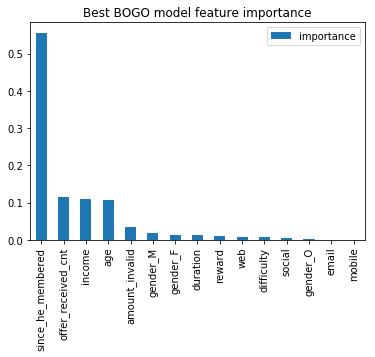

In [98]:
# Bogo_2
import matplotlib.pyplot as plt
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target= attribute_response_variable(offers_bogo,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

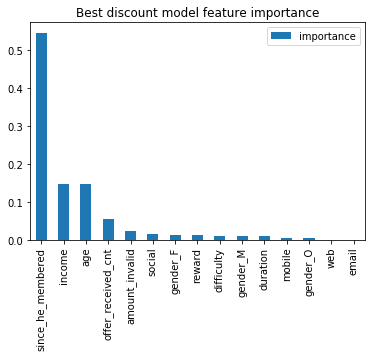

In [99]:
# Discount 2 Model
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

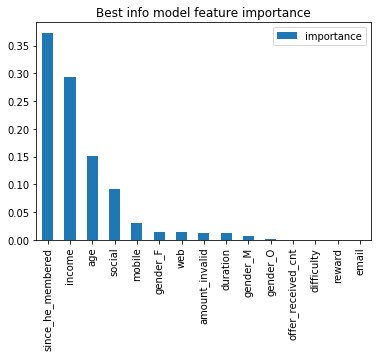

In [101]:
# info_2
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

* Across all we can say since_he_membered is the top feature and second most is income of the user.

    * Bogo
            Here Membership is the most valueble feature and remain all are very nominal impact
    * Discount
            After membership varibale age , income second and thrid most important variables
    * Information
            Comapred to other two datasets income and age are little high importance.


In [102]:
results

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_bogo_1,DecisionTreeClassifier_discount_1,RandomForestClassifier_discount_1,DecisionTreeClassifier_info_1,RandomForestClassifier_info_1,DecisionTreeClassifier_bogo_2,RandomForestClassifier_bogo_2,DecisionTreeClassifier_discount_2,RandomForestClassifier_discount_2,DecisionTreeClassifier_info_2,RandomForestClassifier_info_2,DecisionTreeClassifier_bogo_3,RandomForestClassifier_bogo_3,DecisionTreeClassifier_discount_3,RandomForestClassifier_discount_3,DecisionTreeClassifier_info_3,RandomForestClassifier_info_3
testing_score,0.821806,0.826688,0.872299,0.873477,0.740157,0.745884,0.821806,0.829943,0.872299,0.872692,0.740157,0.752326,0.825468,0.829536,0.872299,0.872299,0.740157,0.753042
training_score,0.822261,0.837420,0.862855,0.872876,0.751119,0.770098,0.822261,0.845050,0.862855,0.872581,0.751119,0.752551,0.823583,0.844847,0.862855,0.875823,0.751119,0.755953


# Summary

### Agenda

* What are the main features influencing the effectiveness of an offer on the Starbucks app?

* Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?

### Findings

### Question 1:

Among all tenure of member is the higest predictor of the effectiveness of an offer.

One good common point while in 3 model preperation tenure of member, income and age are top 3 factors on prediction.

BOGO and discount are quiet un balanced compared to information with top 3 features.

### Question 2:

By the end of 3 model preperations I could say that Bogo and discount are performed better than 80% which is quiet and acceptable business criteria.
BOGO (82.87%)
Discount (87.38%)

Meanwhile, for BOGO and discount models, I am quite happy with the 80% and above accuracy, as in a business setting that would be acceptable to show offers to people, even if the model misclassifies a few, the overall revenue increase might justify the few mistakes.

# Challenges 

### Offer_id assigning:
Classyfying target variable with effective and ineffective basis. while collecting ineffective cases I had lot of complication issues with transaction and offer completed situations.
    
    By taking that up and I designed and ended up with 4 cases:
    
* Group 1 : People who are influenced by offers and thus purchase/complete the offer.
    
* Group 2 : People who receive and an offer but is not influenced and thus no conversion event
    
* Group 3 : People who have conversion events but was not actually influenced by an offer
    
* Group 4 : People who receive offers but no views or action taken
    
Out of all 4 group's allocation, group 3 is tricky and confusing to put down in a proper id sequence of events



-----------------------------------------------------------------------------------------------------------------------------

### Model decisions

I wanted to explore more on effective offer, it would be more clear to remove noise from the data into offer types. Testing results for Bogo and discount proved with good results. On the other hand info score was low since we do have low dataset size.

As I used tree based model prediction models as I wanted to assure feature importance as my agenda, but it could have extended further towards regerssion model. I believe tenure_of_member will not be a higest feature.

# Enhancements

Only time consideration, I did not get much time to deep dive towards feature engineering where we can improvise and remove few attributes to achive better performace.

As far as we most of time been set up on offers to suggest to user, instead we could have add recommendation based system as well as if we could concentrate on customers who have completed transactions without offers.